In [1]:
import pandas
import numpy as np
from sklearn.model_selection import train_test_split

#Load of the dataset and split in training and test set
dataset = pandas.read_csv('edit_intention_dataset_featured.csv', sep=',')
X, y = dataset.iloc[:, :-14], dataset.iloc[:, -14:]
kwargs = dict(test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)

#Now we have the test and set splits done and the data is ready to be analyzed and modeled.


In [2]:
# Feature importance plot. Input the training data and the trained model
def plot_feature_importances(data,attribute_names,model):
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), attribute_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
# Shows the predictions of multiple models.
# Property_index is the index of the most relevant feature (0 by default if feature selection was applied correctly)
def plot_predictions(X_train, X_test, y_train, y_test, models, property_index=0):
    
    X_all = np.concatenate((X_train, X_test),axis=0)
    
    plt.figure(figsize=(8,6))
    plt.rcParams['lines.linewidth'] = 1

    prop = X_all[:,property_index]
    prop_train = X_train[:,property_index]
    prop_test = X_test[:,property_index]


    sort_all = prop.argsort()
    sort_train = prop_train.argsort()
    sort_test = prop_test.argsort()

    plt.scatter(prop_train[sort_train], y_train[sort_train], label="Training data")
    plt.scatter(prop_test[sort_test], y_test[sort_test], label="Test data")
    for name, model in models.items():
        predictions = model.predict(X_all)
        plt.plot(prop[sort_all], predictions[sort_all], label=name)
    plt.xlabel("x")
    plt.ylabel("Vandalism");
    plt.legend()

In [3]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
#This approach is called Model-based feature selection. 
#The model judges the importance of each feature and select
#only the most important ones.

select = SelectFromModel(
    RandomForestClassifier(),
    threshold="median")
select.fit(X_train, y_train['vandalism'])
X_train_l1 = select.transform(X_train)
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

X_test_l1 = select.transform(X_test)
score = RandomForestClassifier().fit(X_train_l1, y_train['vandalism']).score(X_test_l1, y_test['vandalism'])
print("LogisticRegression test score with only selected features: {:.3f}".format(score))
lr = RandomForestClassifier()
lr.fit(X_train, y_train['vandalism'])
print("LogisticRegression score with all features: {:.3f}".format(lr.score(X_test, y_test['vandalism'])))




C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression test score with only selected features: 0.982
LogisticRegression score with all features: 0.984


C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  2   3 181 188 189 192 193] are constant.
  UserWarning)
C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


LogisticRegression score with all features: 0.983
LogisticRegression score with only selected features: 0.983


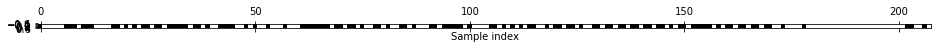

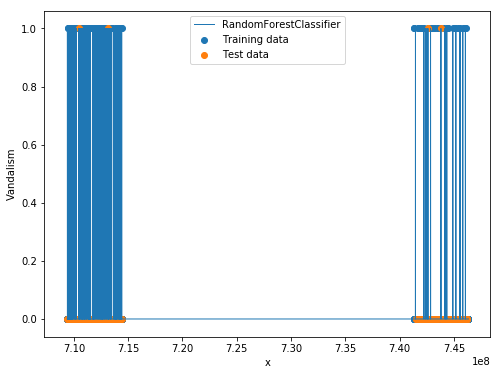

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
#This approach is based on the selection of only a fixed chosen % of attributes, the most valuable ones.

#Used to select the #percentile most valuable for the model
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train['vandalism'])
# transform training set:
X_train_selected = select.transform(X_train)

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

# transform test data:
X_test_selected = select.transform(X_test)

lr = RandomForestClassifier()
lr.fit(X_train, y_train['vandalism'])
print("LogisticRegression score with all features: {:.3f}".format(lr.score(X_test, y_test['vandalism'])))
lr.fit(X_train_selected, y_train['vandalism'])
print("LogisticRegression score with only selected features: {:.3f}".format(
        lr.score(X_test_selected, y_test['vandalism'])))

models = {'RandomForestClassifier':lr}
plot_predictions(X_train_selected, X_test_selected, y_train['vandalism'], y_test['vandalism'], models, property_index=0)


In [5]:
from sklearn.metrics import f1_score

predicted = lr.predict(X_test_selected)
f1_score(y_test['vandalism'], predicted, average = 'micro')

0.9832893579595426

In [41]:
#Dummie to test the predictions of the article leche
#Tried to merge the dataframes of each intention into a complete one but
#was unable to do it, had to usea cheap version with a dictionary

leche = pandas.read_csv('revision_ids_leche_featured.csv', sep=',')
X_leche, y_leche = leche.iloc[:, :-14], dataset.iloc[:, -14:]

intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','other','wikification',
            'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
            'point-of-view']

#results = pandas.DataFrame(columns = intentions)
results = {'revision_id':[],'counter-vandalism':[],'fact-update':[],'refactoring':[],'copy-editing':[],'other':[],'wikification':[],
            'vandalism':[],'simplification':[],'elaboration':[],'verifiability':[],'process':[],'clarification':[],'disambiguation':[],
            'point-of-view':[]}

results['revision_id'] = leche.iloc[:,0]

for intention in intentions:
    
    #results_intention = pandas.Series([], name = intention)
    #results_intention = pandas.DataFrame( columns = [intention])
    
    print("Predicting labels for " + intention)
    
    lr.fit(X_train, y_train[intention])
    predictions_leche = lr.predict(X_leche)
    
    for line in predictions_leche:
        #results_intention = results_intention.append({intention:line}, ignore_index = True)
        #results_intention.add(line)
        #results.loc[results.index[counter], intention] = line
        results[intention].append(line)
        
results_dataframe = pandas.DataFrame.from_dict(results)
    #results = pandas.concat([results,results_intention], axis = 1, sort = False)
    #results = results.merge(results_intention, how = 'outer')
      

results_dataframe.to_csv(path_or_buf = 'leche_labels.csv', index = False)




Predicting labels for counter-vandalism
Predicting labels for fact-update
Predicting labels for refactoring
Predicting labels for copy-editing
Predicting labels for other
Predicting labels for wikification
Predicting labels for vandalism
Predicting labels for simplification
Predicting labels for elaboration
Predicting labels for verifiability
Predicting labels for process
Predicting labels for clarification
Predicting labels for disambiguation
Predicting labels for point-of-view


In [107]:
#Now the idea is to add the created labels to the initial parsed dump

output = pandas.read_csv('leche.csv', sep=',')

attributes = {'page_id':[], 'page_title':[], 'page_ns':[], 'revision_id':[],'intentionality':[],'timestamp':[],
       'contributor_id':[], 'contributor_name':[], 'bytes':[]}

#values = {'counter-vandalism':'0','fact-update':'1','refactoring':'2','copy-editing':'3','other':'4','wikification':'5',
#            'vandalism':'6','simplification':'7','elaboration':'8','verifiability':'9','process':'10','clarification':'11',
#          'disambiguation':'12','point-of-view':'13'}

labels = [None] * len(results_dataframe.index)



#output = pandas.DataFrame.to_dict(output)

for intention in intentions:
    
    offset = 0
    
    for line in results[intention]:
        
        if labels[offset] == None:
            labels[offset] = str(results['revision_id'][offset]) + ':'
        if line == 1:
            labels[offset] = labels[offset] + intention + ','
        
        offset += 1

        
labels_dataframe = pandas.DataFrame(columns=['revision_id', 'intentionality'])
for line in labels:
   
    data = line.split(':')
    data_id = data[0]
    data_intention = data[1]
    
    data = pandas.DataFrame({'revision_id':[data_id],'intentionality':[data_intention]})
    labels_dataframe = labels_dataframe.append(data)


labels_dataframe['revision_id']=labels_dataframe['revision_id'].astype(int)
output = output.merge(labels_dataframe, on = 'revision_id', how = 'inner')


output.to_csv(path_or_buf = 'leche_dataset_process_mining.csv', index = False)
